In [1]:
import rasterio
import geopandas as gpd
import numpy as np
import pandas as pd
from numpy import percentile
from shapely.geometry import box
from rasterio.features import rasterize
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from rasterio.plot import show
import geopandas as gpd
from shapely.geometry import box

def normalize_band(band):
    return (band - band.min()) / (band.max() - band.min())

# Función para aplicar un estiramiento basado en percentiles
def stretch_band(band, low_percent=2, high_percent=98):
    low, high = percentile(band, (low_percent, high_percent))
    band_stretched = np.clip((band - low) / (high - low), 0, 1)
    return band_stretched

# Visualizar la imagen RGB y superponer el shapefile
# def visualize_raster_with_shapefile(src, shapefile):
def visualize_raster_with_shapefile(image, shapefile, bounds):
    """
    Muestra la imagen RGB con las etiquetas del shapefile superpuestas.
    Args:
        image (rasterio.io.DatasetReader): Imagen raster cargada con rasterio.
        shapefile (geopandas.GeoDataFrame): Shapefile con las etiquetas.
    """
    # image = src.read()
    r_norm = stretch_band(image[0])
    g_norm = stretch_band(image[1])
    b_norm = stretch_band(image[2])

    # transform = src.transform
    # bounds = src.bounds  # Extremos del área cubierta
    extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]

    # Validar CRS
    # if shapefile.crs != src.crs:
    #     print("Reproyectando shapefile al CRS del raster.")
    #     shapefile = shapefile.to_crs(src.crs)

    # Recortar shapefile a los límites del raster
    # bounds = box(*src.bounds)
    # shapefile_clipped = shapefile[shapefile.intersects(bounds)]
    # print(f"Polígonos restantes después del recorte: {len(shapefile_clipped)}")
    # shapefile_clipped = shapefile_clipped[shapefile.is_valid]

    # Revisar si el shapefile tiene geometrías válidas
    # print("Número de geometrías:", len(shapefile_clipped))
    # print("¿Geometrías válidas?", shapefile_clipped.is_valid.all())
    # print("Primeras filas del shapefile:", shapefile_clipped.head())

    # Leer las bandas RGB de la imagen
    # rgb_image = image.read([1, 2, 3]).transpose(1, 2, 0)  # Cambiar a formato HxWxC

    # minxr, minyr, maxxr, maxyr = src.bounds
    # print(minxr, minyr, maxxr, maxyr)

    # Configurar el gráfico
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(np.dstack((r_norm, g_norm, b_norm)), extent=extent, origin="upper", cmap="viridis")  # Normalizar valores para matplotlib (0-1)

    # Superponer el shapefile
    # shapefile_clipped.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=1.5)
    shapefile.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=1.5)

    # Agregar leyendas y ajustar
    ax.set_title("Imagen con etiquetas superpuestas", fontsize=14)
    ax.axis('off')

    plt.tight_layout()
    plt.show()

In [2]:
import matplotlib.pyplot as plt
from rasterio.plot import show
from rasterio.mask import mask

# Función para visualizar resultados
def visualize_results(image, shapefile, predictions, transform, region_bounds=None):
    """
    Visualiza los datos originales, las etiquetas del shapefile y las predicciones.
    Args:
        image (numpy array): Array con las bandas del GeoTIFF (C, H, W).
        shapefile (GeoDataFrame): Shapefile con etiquetas reales.
        predictions (numpy array): Predicciones del modelo (H, W).
        transform (Affine): Transformación del raster original.
        region_bounds (tuple): Coordenadas de la región (minx, miny, maxx, maxy). Opcional.
    """
    # 1. Seleccionar una región (si se especifica)
    if region_bounds:
        # Recortar la imagen original
        minx, miny, maxx, maxy = region_bounds
        shapes = [gpd.GeoSeries.from_bbox((minx, miny, maxx, maxy)).__geo_interface__]
        image_crop, transform_crop = mask(image, shapes, crop=True)
        predictions_crop, _ = mask(predictions, shapes, crop=True)
    else:
        image_crop = image
        transform_crop = transform
        predictions_crop = predictions

    # Rasterizar el shapefile para la región seleccionada
    if region_bounds:
        shapefile_clipped = shapefile.cx[minx:maxx, miny:maxy]
    else:
        shapefile_clipped = shapefile
    
    labels_raster = rasterize(
        [(geom, value) for geom, value in zip(shapefile_clipped.geometry, shapefile_clipped["label"])],
        out_shape=(image_crop.shape[1], image_crop.shape[2]),
        transform=transform_crop,
        fill=0,
        dtype="uint8",
    )


    print(predictions_crop.shape)
    print(np.unique(predictions))


    # Predicciones del modelo
    # Asegurar que las dimensiones sean correctas
    predictions_crop = predictions_crop.squeeze()  # Asegura (H, W)
    print(labels_raster)
    print(predictions_crop)

    # 2. Visualizar resultados

    r_norm = stretch_band(image_crop[0])
    g_norm = stretch_band(image_crop[1])
    b_norm = stretch_band(image_crop[2])

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    axs[0].set_title("Imagen original (RGB)")
    axs[0].imshow(np.dstack((r_norm, g_norm, b_norm)), cmap="viridis")
    axs[0].axis("off")

    axs[1].set_title("Shapefile rasterizado (etiquetas reales)")
    axs[1].imshow(labels_raster, cmap="coolwarm", interpolation="none")
    axs[1].axis("off")

    # Visualizar con un mapa de colores adecuado
    axs[2].set_title("Predicción del modelo")
    axs[2].imshow(predictions_crop, cmap="coolwarm", interpolation="none")
    axs[2].axis("off")

    plt.tight_layout()
    plt.show()


Polígonos restantes después del recorte: 1382


c:\Data\UCA\Tesis\Colabs\test_env\Lib\site-packages\geopandas\geodataframe.py:1750: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


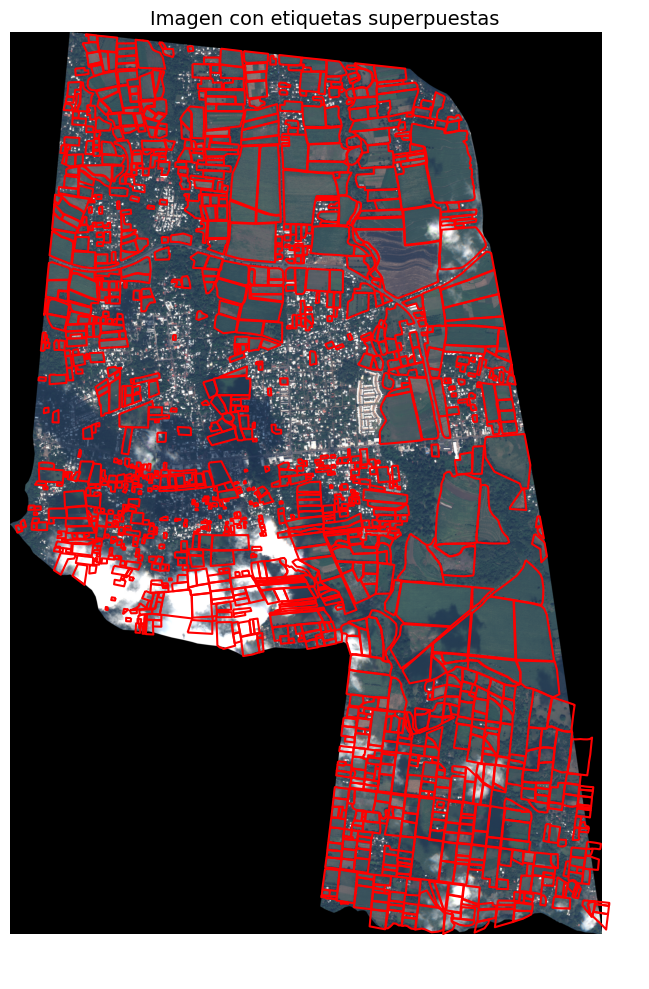

In [3]:
# Cargamos el shapefile
shapefile = gpd.read_file("./data/Data/fields_sta_maria/fields.shp")
# Cargamos el GeoTIFF
src = rasterio.open("./data/SKYWATCH_SS_PS_20221214T1812_TC_Tile_0_0_7c69.tif")

# 2. Preprocesamiento (Normalizacion)
image = src.read()
r_norm = stretch_band(image[0])
g_norm = stretch_band(image[1])
b_norm = stretch_band(image[2])

transform = src.transform
bounds = src.bounds  # Extremos del área cubierta
extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]

# Validar CRS
if shapefile.crs != src.crs:
    print("Reproyectando shapefile al CRS del raster.")
    shapefile = shapefile.to_crs(src.crs)

# Recortar shapefile a los límites del raster
bounds = box(*src.bounds)
shapefile_clipped = shapefile[shapefile.intersects(bounds)]
print(f"Polígonos restantes después del recorte: {len(shapefile_clipped)}")
shapefile_clipped = shapefile_clipped[shapefile.is_valid]

# Crear un array de características
features = np.stack([r_norm.ravel(), g_norm.ravel(), b_norm.ravel()], axis=-1)
shapefile_clipped['type'] = 'cultivo' # Se asume que todos son justo los cultivos
shapefile_clipped["label"] = shapefile_clipped["type"].apply(lambda x: 1 if x == "cultivo" else 0)

visualize_raster_with_shapefile(image, shapefile_clipped, src.bounds)


In [ ]:
import dask.array as da

# Crear un raster binario
labels_raster = rasterize(
    [(geom, value) for geom, value in zip(shapefile_clipped.geometry, shapefile_clipped["label"])],
    out_shape=(src.height, src.width),
    transform=transform,
    fill=0,  # Valor para áreas no clasificadas
    dtype="uint8"
)

# Aplanar las etiquetas
labels = labels_raster.ravel()  # Etiquetas

# Filtrar píxeles con etiquetas válidas
# valid_pixels = labels > 0
# features_valid = features[valid_pixels]
# labels_valid = labels[valid_pixels]

features_valid = features
labels_valid = labels

 # Dividir datos
X_train, X_test, y_train, y_test = train_test_split(features_valid, labels_valid, test_size=0.3, train_size=0.7, random_state=42)

# Etiquetas del conjunto de entrenamiento
unique, counts = np.unique(y_train, return_counts=True)
print("Distribución de clases en el conjunto de entrenamiento:")
for cls, count in zip(unique, counts):
    print(f"Clase {cls}: {count} píxeles")

### Cualquiera de los enfoques de abajo da Memory Error
# Es de probar correrlo en el servidor pero para ello hay que implementar
# el guardado del resultado en archivos para poderlo luego visualizar

# Entrenar modelo
# model = RandomForestClassifier(n_estimators=100, random_state=42)
# model.fit(X_train, y_train)

# Convertir datos a Dask
X_dask = da.from_array(X_train, chunks=(10000, X_train.shape[1]))
y_dask = da.from_array(y_train, chunks=10000)

# Entrenar modelo
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_dask, y_dask)


Distribución de clases en el conjunto de entrenamiento:
Clase 0: 46099863 píxeles
Clase 1: 26748179 píxeles


MemoryError: could not allocate 2147483648 bytes

In [ ]:
# Evaluar el modelo
# y_pred = model.predict(X_test).reshape(image[1].shape)
# print(classification_report(y_test, y_pred, labels=[1], target_names=["Cultivo"]))

# El problema está en que esta instrucción de abajo predice todo en 1
y_pred = model.predict(features)
print(classification_report(labels, y_pred, labels=[1], target_names=["Cultivo"]))

# Para probar que si se muestra bien, generamos aleatoreamente valores a cero en el 90% de los pixeles
# indices = np.random.choice(np.arange(y_pred.size), replace=False, size=int(y_pred.size * 0.9))
# y_pred[indices] = 0

y_pred = y_pred.reshape(image[1].shape)

y_pred

In [ ]:
visualize_results(image, shapefile_clipped, y_pred, transform)